In [1]:
import pandas as pd
import seaborn as sns
import sys,os,argparse
from IPython.display import HTML
import numpy as np 
from sklearn import preprocessing
from numpy.linalg import matrix_rank
import statsmodels.discrete.discrete_model as sm
from statsmodels.api import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import metrics
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os 
os.chdir("/home/mahima/1.mahima/ML/Cig Tuple/SigTuple_IPL_ProblemStatement/IPL")

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

# DATA PREPROCESSING

In [3]:
train=train.drop(['DateOfGame','Game ID'],axis=1)
test=test.drop(['DateOfGame','Game ID'],axis=1)

In [4]:
float_columns = train.select_dtypes(include=['float64']).columns
int_columns = train.select_dtypes(include=['int64']).columns
numeric_columns = float_columns.union(int_columns).drop(['DayOfWeek'])
numeric_columns = numeric_columns.drop(['Winner (team 1=1, team 2=0)'])
categorical_columns = train.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.union(['DayOfWeek'])

In [5]:
print("Test missing columns",set( train.columns ) - set( test.columns ))
print("Train missing columns",set( test.columns ) - set( train.columns ))

Test missing columns {'City', 'DayOfWeek'}
Train missing columns {'CityOfGame', 'Day'}


In [6]:
test = test.rename(columns={'Day': 'DayOfWeek', 'CityOfGame': 'City'})

In [7]:
print("Test missing columns",set( train.columns ) - set( test.columns ))
print("Train missing columns",set( test.columns ) - set( train.columns ))

Test missing columns set()
Train missing columns set()


In [8]:
# for col_  in train_numeric_columns:
#     sns.boxplot(x=train_data[col_])  

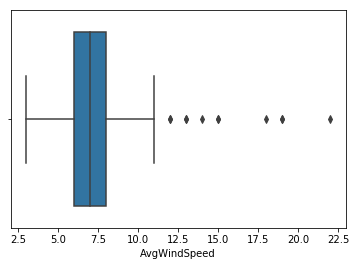

In [9]:
sns.boxplot(x=train['AvgWindSpeed'])

In [10]:
def replace_with_median(data,column):
    quartile_1, quartile_3 = np.percentile(data[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (float(iqr) * 1.5)
    upper_bound = quartile_3 + (float(iqr) * 1.5)
    data.loc[(data[column]<lower_bound) | (data[column] > upper_bound),[column]] = data[column].median()
    return data[column]

Outlier Treatment

In [11]:
for numeric_column in numeric_columns:
    train[numeric_column] = replace_with_median(train,numeric_column)

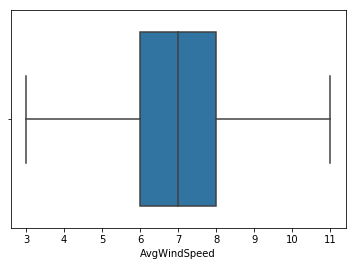

In [12]:
sns.boxplot(x=train['AvgWindSpeed'])

Normalization of train and test data

In [13]:
min_max_scaler = preprocessing.MinMaxScaler() 
train_scaled_numeric = pd.DataFrame(min_max_scaler.fit_transform(train[numeric_columns]),columns = numeric_columns)
test_scaled_numeric = pd.DataFrame(min_max_scaler.transform(test[numeric_columns]),columns = numeric_columns)

In [14]:
def one_hot_encode(data,col):
    y = pd.get_dummies(data[col],prefix=col)
    data.drop(columns = [col],axis=1,inplace=True)
    return y    

In [15]:
onehotencoded_train  = pd.concat([one_hot_encode(train,col) for col in categorical_columns], axis=1) 
onehotencoded_test  = pd.concat([one_hot_encode(test,col) for col in categorical_columns], axis=1)

In [16]:
missing_cols = set(onehotencoded_train.columns) - set( onehotencoded_test.columns )
for c in missing_cols:
    onehotencoded_test[c] = 0
onehotencoded_test=onehotencoded_test[onehotencoded_train.columns]

In [17]:
train_x = pd.concat([train_scaled_numeric,onehotencoded_train],axis=1)
test_x = pd.concat([test_scaled_numeric,onehotencoded_test],axis=1)

In [18]:
train_x.shape

(252, 68)

In [19]:
test_x.shape

(76, 68)

In [20]:
train_y = train["Winner (team 1=1, team 2=0)"]
test_y = test["Winner (team 1=1, team 2=0)"]

In [21]:
train_x.head(2)

,AvgHumidity,AvgWindSpeed,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,"Inn 1 Team 1 NOP R<25, SR>125","Inn 1 Team 1 NOP R>25,SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 2 Extras conceded in_wides_No Balls,Inn 1 Team 2 NoP Spinners,Inn 1 Team 2 NoP fast bowlers,...,TimeOfGame_15:00:00,TimeOfGame_16:00:00,TimeOfGame_16:30:00,TimeOfGame_16:45:00,TimeOfGame_17:00:00,TimeOfGame_17:10:00,TimeOfGame_18:50:00,TimeOfGame_20:00:00,TimeOfGame_20:15:00,TimeOfGame_20:30:00
0,0.277778,0.375,0.559663,0.333333,0.333333,0.523810,0.384615,0.692308,0.333333,0.666667,...,0,0,0,0,0,0,0,1,0,0
1,0.185185,0.500,0.705363,0.666667,1.000000,0.761905,0.384615,0.307692,0.333333,1.000000,...,0,0,0,0,1,0,0,0,0,0


In [22]:
test_x.head(2)

,AvgHumidity,AvgWindSpeed,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,"Inn 1 Team 1 NOP R<25, SR>125","Inn 1 Team 1 NOP R>25,SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 2 Extras conceded in_wides_No Balls,Inn 1 Team 2 NoP Spinners,Inn 1 Team 2 NoP fast bowlers,...,TimeOfGame_15:00:00,TimeOfGame_16:00:00,TimeOfGame_16:30:00,TimeOfGame_16:45:00,TimeOfGame_17:00:00,TimeOfGame_17:10:00,TimeOfGame_18:50:00,TimeOfGame_20:00:00,TimeOfGame_20:15:00,TimeOfGame_20:30:00
0,0.518519,0.250,0.233994,0.333333,0.333333,0.095238,0.076923,0.538462,0.333333,0.666667,...,0,0,0,0,0,0,0,1,0,0
1,0.592593,0.375,0.479116,1.000000,0.333333,0.095238,0.384615,0.153846,0.500000,0.333333,...,0,0,0,0,0,0,0,1,0,0


# MODEL BUILDING

## Support Vector Machine

In [23]:
clf = svm.SVC(kernel='linear') 
clf.fit(train_x, train_y) 
pred_svm_1=clf.predict(train_x)
pred_svm_2=clf.predict(test_x)
fpr, tpr, threshold= metrics.roc_curve(train_y, pred_svm_1)
AUC= metrics.auc(fpr,tpr) # to get the area under the Curve
print("Train AUC : ",AUC)
fpr, tpr, threshold= metrics.roc_curve(test_y, pred_svm_2)
AUC= metrics.auc(fpr,tpr) # to get the area under the Curve
print("Test AUC : ",AUC)

Train AUC :  0.9552424765190722
Test AUC :  0.9145658263305322


# Random Forest Classifier

In [24]:
classifier = RandomForestClassifier(n_estimators=20, random_state=0)  
classifier.fit(train_x, train_y)  
pred_RF_1 = classifier.predict(train_x)
pred_RF_2 = classifier.predict(test_x)
fpr, tpr, threshold= metrics.roc_curve(train_y, pred_RF_1)
AUC= metrics.auc(fpr,tpr) # to get the area under the Curve
print("Train AUC : ",AUC)
fpr, tpr, threshold= metrics.roc_curve(test_y, pred_RF_2)
AUC= metrics.auc(fpr,tpr) # to get the area under the Curve
print("Test AUC : ",AUC)

Train AUC :  1.0
Test AUC :  0.8403361344537815


# Logistic Regression

First Treating multicollinearity using Rank of Matrix

In [25]:
i = 1
while(i <= train_x.shape[1]):
    #print(train_x.columns[i-1])
    if matrix_rank(train_x.iloc[:,:i])!=i:
        print("Dropping due to multicollinearity",train_x.columns[i-1]) 
        train_x.drop(train_x.columns[i-1], axis=1,inplace=True) 
        test_x.drop(test_x.columns[i-1], axis=1,inplace=True)         
    else:
        i = i+1     

Dropping due to multicollinearity DayOfWeek_7
Dropping due to multicollinearity Team 1_Whitefield Water Loggers 
Dropping due to multicollinearity Team 2_Whitefield Water Loggers 
Dropping due to multicollinearity TimeOfGame_20:30:00


multicollinearity led to dropping 4 columns

In [26]:
train_x.shape, test_x.shape

((252, 64), (76, 64))

VIF for the columns is checked and ones having VIF>10 are dropped. in case above has not properly dropped all the columns

In [27]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_x.values, i) for i in range(train_x.shape[1])]
vif["features"] = train_x.columns

In [28]:
col_with_VIF_morethan10=vif.loc[vif['VIF Factor']>10]['features'].tolist()

In [29]:
vif.loc[vif['VIF Factor']>10]

,VIF Factor,features
22,26.484393,City_Bellandur
23,37.393667,City_Electronic City
24,39.314939,City_Indranagar
25,55.375459,City_Koramangala
26,69.053948,City_Marathalli
27,57.801206,City_Sarjapur
28,35.877756,City_Silkboard
29,45.775311,City_Whitefield
54,13.739256,TimeOfGame_12:30:00
56,29.002605,TimeOfGame_16:00:00


In [30]:
train_x.drop(col_with_VIF_morethan10,inplace=True,axis=1)
test_x=test_x[train_x.columns]

In [31]:
train_x.shape

(252, 52)

In [32]:
pd.concat([train_x,train_y],axis=1).to_csv("TrainFinal.csv",index=False)
pd.concat([test_x,test_y],axis=1).to_csv("TestFinal.csv",index=False)

Summary of the results is obtained. The ones having p value<0.05 can be removed and then the rest of data can be fed to the model.

In [33]:
X2 = add_constant(train_x)
logit = sm.Logit(list(train_y), X2)
result = logit.fit(method='bfgs')
print(result.summary())

         Current function value: 0.101866
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  252
Model:                          Logit   Df Residuals:                      199
Method:                           MLE   Df Model:                           52
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                  0.8515
Time:                        23:41:52   Log-Likelihood:                -25.670
converged:                      False   LL-Null:                       -172.88
                                        LLR p-value:                 1.427e-35
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Working with Logistic Regression

In [34]:
log_reg=LogisticRegression(C = 1e9,class_weight = 'balanced')  
log_reg.fit(train_x,train_y)
pred_train=log_reg.predict(train_x)
pd.crosstab(train_y,pred_train)

col_0,0,1
"Winner (team 1=1, team 2=0)",,
0,141,0
1,0,111


In [35]:
pred_test=log_reg.predict(test_x)
pd.crosstab(test_y,pred_test)

col_0,0,1
"Winner (team 1=1, team 2=0)",,
0,38,4
1,6,28


Train AUC:  1.0


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


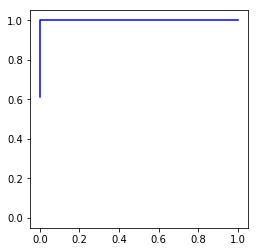

In [36]:
pred_train=log_reg.predict_proba(train_x)
fpr, tpr, threshold= metrics.roc_curve(train_y, pred_train[:,1]) 
plt.plot(fpr, tpr, label='ROC curve', color='b')
plt.axes().set_aspect('equal')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
AUC= metrics.auc(fpr,tpr) 
print("Train AUC: ",AUC)

Test AUC 0.9313725490196079


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


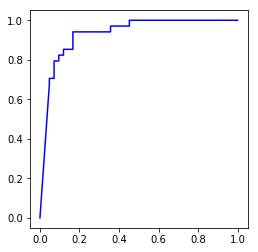

In [39]:
pred_test=log_reg.predict_proba(test_x)
fpr, tpr, threshold= metrics.roc_curve(test_y, pred_test[:,1])  
plt.plot(fpr, tpr, label='ROC curve', color='b')
plt.axes().set_aspect('equal')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
AUC= metrics.auc(fpr,tpr)
print("Test AUC",AUC) 

We need to remove these multicollinear columns for LR, in SVM and random forest we don't need that